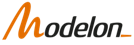

# Run simulations using external data files
This notebook will showcase how to run simulations for the Ingenuity helicopter models where the inputs (position, velocity or angles) are defined as time series data in a JSON file using the [Modelon Impact Client Library](https://modelon-impact-client.readthedocs.io/en/latest/)(MIC).

## Approach
To showcase how a simulation can be run using input data from an external file, we will perform the following steps:

1. Create a client object and authenticate
2. Configure analysis
3. Run base model and inspect result
4. Generate a temporary data file 
5. Update the model to use this temporary data file
6. Run tweaked model again and compare results

Note there are some basic steps that needs to be performed before start using MIC, documentation is linked below:

1. Install MIC: https://modelon-impact-client.readthedocs.io/en/latest/install.html
2. Authentication: https://modelon-impact-client.readthedocs.io/en/latest/setup.html

If you are running Jupyter Hub for Modelon Impact, MIC is installed by default, so the installation step can be skipped.


In [1]:
import sys

!{sys.executable} -m pip show modelon-impact-client
#!{sys.executable} -m pip install modelon-impact-client==1.1.0

Name: modelon-impact-client
Version: 2.1.0
Summary: Client library for easy scripting against Modelon Impact
Home-page: https://www.modelon.com/modelon-impact
Author: WEP
Author-email: impact@modelon.com
License: BSD
Location: /usr/bin/oct/py3venv/lib/python3.9/site-packages
Requires: requests, semantic_version
Required-by: 


## Create a client object and authenticate
The client object contains methods to authenticate logins, create new workspaces and
upload or fetch existing workspaces

The class constructor has two important parameters:
   - `url`:
       - The URL for Modelon Impact client host. Default is 'http://localhost:8080/', which is used by default for a desktop installation. This is also the URL that should be used if you are using JupyterLab on Modelon Impact Cloud.

   - `interactive`:
       - Asks you to enter an api_key from the prompt. When the key has been entered the first time, it will be stored in the credentials file to be used in future requests, and the prompt will not be shown again. If the key is changed, the file may be deleted which will cause the prompt to be shown again.

In the below cell, a client object is instantiated. Make sure that the URL is pointing towards your Modelon Impact server. When executed, it will also ask for an api key, please go ahead and provide your personal key generated with the API key manager.

In [2]:
from modelon.impact.client import Client

client = Client(url="http://localhost:8080", interactive=True)

## Configure analysis

In below cell a standard dynamic simulation is setup for the model `Ingenuity.Experiments.ExternalControl.AltitudeVelocityRollPitch`.

In [3]:
model_name = "Ingenuity.Experiments.ExternalControl.AltitudeVelocityRollPitch"
workspace = client.get_workspace("Perseverance")
analysis = workspace.get_custom_function('dynamic').with_parameters(start_time=0.0, final_time=30.0)
model = workspace.get_model(model_name)

We use default options, but compiler, runtime and simulation options can be edited if needed.

In [4]:
compiler_options = analysis.get_compiler_options()
runtime_options = analysis.get_runtime_options()
simulation_options = analysis.get_simulation_options()

Experiment definitions are set up using the `.new_experiment_definition()` method from the model object. After this step we are ready to simulate.

In [5]:
experiment_definition = model.new_experiment_definition(analysis, compiler_options=compiler_options, runtime_options=runtime_options, simulation_options=simulation_options)

## Run base model and inspect the result

The experiment definition we have set up can now be passed to the `execute()` method of the workspace object. This will send a request to the server telling it to execute the declared experiment setup in the workspace related to the workspace object. We use the `wait()` method as the execution will take some time to perform. Once the experiment execution is completed, it will return an Experiment object representing the experiment result. The experiment will compile the model if necessery, i.e. if there is no previously compiled fmu of the same model in the workspace.

The `wait()` method generates a lot of logging output, which can be suppressed using Python's built in `logging` module (default is INFO).

In [6]:
import logging

logging.getLogger('modelon.impact.client').setLevel(logging.INFO)

In [7]:
exp = workspace.execute(experiment_definition).wait()

In [8]:
print(exp.get_cases()[0].get_log())

Final Run Statistics: --- 

 Number of steps                                 : 13383
 Number of function evaluations                  : 19389
 Number of Jacobian evaluations                  : 248
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 1239
 Number of nonlinear iterations                  : 19370
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 13415
 Number of state events                          : 3
 Number of time events                           : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-08
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 30.0 seconds.
Elapsed simulation time: 2.2699701140008983 seconds.

Model printouts: ---

Model messages:

DataAccess.JSON v3.7.9418, Copy

Experiments are divided into cases. For the previous definition we only have one case. We can inspect the results for a specific case by calling the Experiment object's `get_trajectories()` method and using matplotlib to do the actual plotting. 

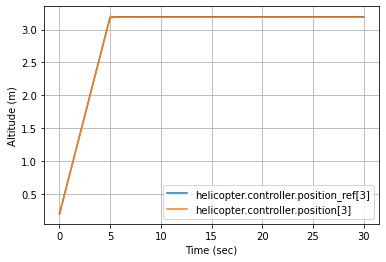

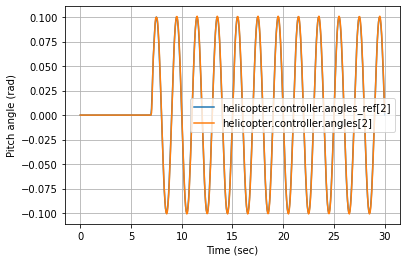

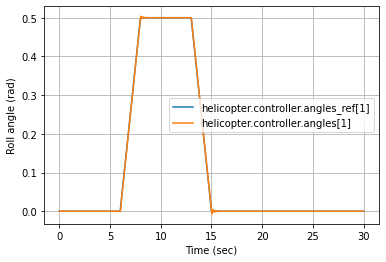

In [9]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()
for case in exp.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.position_ref[3]'])
        plt.plot(res['time'], res['helicopter.controller.position[3]'])
        plt.legend(['helicopter.controller.position_ref[3]', 'helicopter.controller.position[3]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
for case in exp.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.angles_ref[2]'])
        plt.plot(res['time'], res['helicopter.controller.angles[2]'])
        plt.legend(['helicopter.controller.angles_ref[2]', 'helicopter.controller.angles[2]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Pitch angle (rad)')
plt.grid()
plt.show()

plt.figure(3)
plt.clf()
for case in exp.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.angles_ref[1]'])
        plt.plot(res['time'], res['helicopter.controller.angles[1]'])
        plt.legend(['helicopter.controller.angles_ref[1]', 'helicopter.controller.angles[1]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Roll angle (rad)')
plt.grid()
plt.show()

## Change pitch angle trajectory in input JSON file and run the simulation
 
It is possible to change path of the file containing the input data. Here an example is shown by modifying an existing file (In this case setting the pitch angle to 0 deg) and saving it in a temporary folder. An alternative is to change the data in the existing file. In that case the `access.filename` modifier needs to removed from the experiment definition

In [10]:
# Change pitch trajectory in Helicopter_inputs.json and save it as Helicopter_inputs_2.json
# Alternatively change Helicopter_inputs.json and remove access.filename modifier in next cell

import json
import tempfile

with open('/home/jovyan/impact/workspaces/Perseverance/model_libraries/editable/Ingenuity/Resources/data/Helicopter_inputs.json','r') as outfile:
    data=outfile.read()

obj=json.loads(data)
obj['data_access']['pitch']=[[0,0],[1,0],[2,0]]

tfile = tempfile.NamedTemporaryFile(mode="w+",suffix='.json')
json.dump(obj, tfile)
tfile.flush()
print(tfile.name)


/tmp/tmp3zu4r4d0.json


The temporary file generated in the previous cell is now used as the input file for the simulation

In [11]:
experiment_definition_new = experiment_definition.with_modifiers({'access.filename':tfile.name})

exp_new = workspace.execute(experiment_definition_new).wait()

print(exp_new.get_cases()[0].get_log())

Final Run Statistics: --- 

 Number of steps                                 : 3336
 Number of function evaluations                  : 3977
 Number of Jacobian evaluations                  : 61
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 117
 Number of nonlinear iterations                  : 3958
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3372
 Number of state events                          : 3
 Number of time events                           : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-08
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 30.0 seconds.
Elapsed simulation time: 0.6253286709979875 seconds.



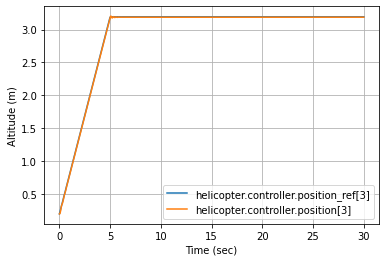

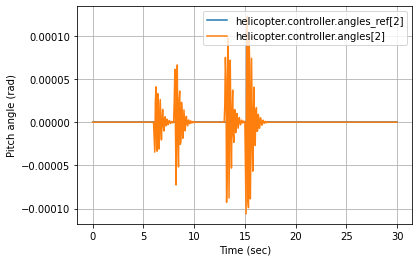

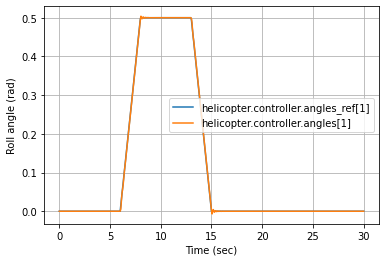

In [12]:
plt.figure(1)
plt.clf()
for case in exp_new.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.position_ref[3]'])
        plt.plot(res['time'], res['helicopter.controller.position[3]'])
        plt.legend(['helicopter.controller.position_ref[3]', 'helicopter.controller.position[3]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
for case in exp_new.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.angles_ref[2]'])
        plt.plot(res['time'], res['helicopter.controller.angles[2]'])
        plt.legend(['helicopter.controller.angles_ref[2]', 'helicopter.controller.angles[2]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Pitch angle (rad)')
plt.grid()
plt.show()

plt.figure(3)
plt.clf()
for case in exp_new.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.angles_ref[1]'])
        plt.plot(res['time'], res['helicopter.controller.angles[1]'])
        plt.legend(['helicopter.controller.angles_ref[1]', 'helicopter.controller.angles[1]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Roll angle (rad)')
plt.grid()
plt.show()

## Running multiple configurations

The controller in the helicopter model has been setup to switch between velocity and angles being used as input through the use of `enable_angles_input` Boolean parameter. It can be set using the python client as a modifier to rerun the simulation with the velocity tables defines in the input file instead

Final Run Statistics: --- 

 Number of steps                                 : 5932
 Number of function evaluations                  : 6714
 Number of Jacobian evaluations                  : 101
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 123
 Number of nonlinear iterations                  : 6707
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 5934
 Number of time events                           : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-08
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 30.0 seconds.
Elapsed simulation time: 0.9691985780009418 seconds.



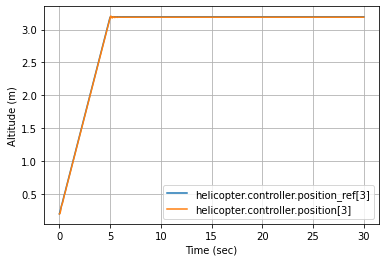

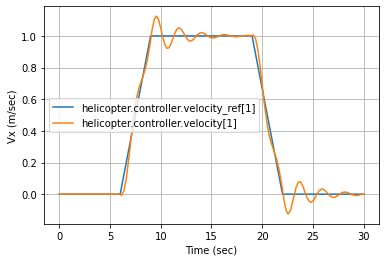

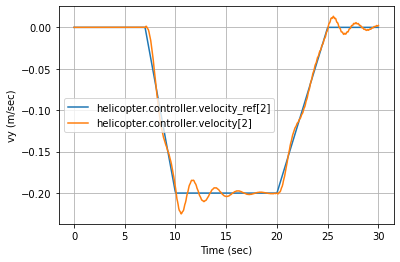

In [13]:
experiment_definition_velocity = experiment_definition.with_modifiers({'helicopter.controller.enable_angles_input':False})

exp_velocity = workspace.execute(experiment_definition_velocity).wait()

print(exp_velocity.get_cases()[0].get_log())

plt.figure(1)
plt.clf()
for case in exp_velocity.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.position_ref[3]'])
        plt.plot(res['time'], res['helicopter.controller.position[3]'])
        plt.legend(['helicopter.controller.position_ref[3]', 'helicopter.controller.position[3]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
for case in exp_velocity.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.velocity_ref[1]'])
        plt.plot(res['time'], res['helicopter.controller.velocity[1]'])
        plt.legend(['helicopter.controller.velocity_ref[1]', 'helicopter.controller.velocity[1]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Vx (m/sec)')
plt.grid()
plt.show()

plt.figure(3)
plt.clf()
for case in exp_velocity.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.velocity_ref[2]'])
        plt.plot(res['time'], res['helicopter.controller.velocity[2]'])
        plt.legend(['helicopter.controller.velocity_ref[2]', 'helicopter.controller.velocity[2]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('vy (m/sec)')
plt.grid()
plt.show()

The next cell demonstrates the simulation of the position control variant of the helicopter model

Final Run Statistics: --- 

 Number of steps                                 : 5932
 Number of function evaluations                  : 6714
 Number of Jacobian evaluations                  : 101
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 123
 Number of nonlinear iterations                  : 6707
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 5934
 Number of time events                           : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-08
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 30.0 seconds.
Elapsed simulation time: 0.9691985780009418 seconds.



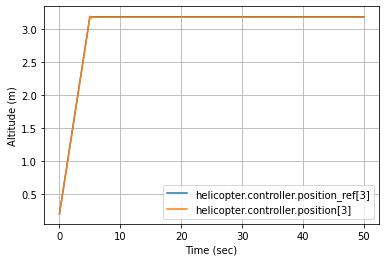

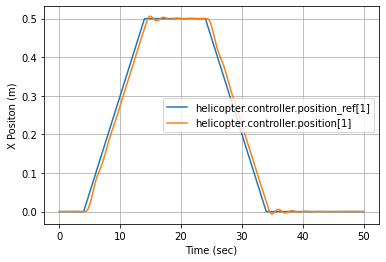

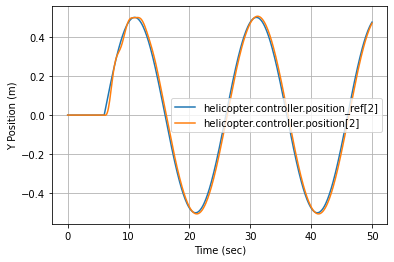

In [14]:
model = workspace.get_model("Ingenuity.Experiments.ExternalControl.AltitudePositionRollPitch")
fmu = model.compile(compiler_options=compiler_options).wait()

experiment_definition = model.new_experiment_definition(
   analysis.with_parameters(start_time=0.0, final_time=50),
   simulation_options=analysis.get_simulation_options().with_values(ncp=500)
).with_modifiers()

exp = workspace.execute(experiment_definition).wait()

print(exp_velocity.get_cases()[0].get_log())

plt.figure(1)
plt.clf()
for case in exp.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.position_ref[3]'])
        plt.plot(res['time'], res['helicopter.controller.position[3]'])
        plt.legend(['helicopter.controller.position_ref[3]', 'helicopter.controller.position[3]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

plt.figure(2)
plt.clf()
for case in exp.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.position_ref[1]'])
        plt.plot(res['time'], res['helicopter.controller.position[1]'])
        plt.legend(['helicopter.controller.position_ref[1]', 'helicopter.controller.position[1]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('X Positon (m)')
plt.grid()
plt.show()

plt.figure(3)
plt.clf()
for case in exp.get_cases():
    if case.is_successful():
        res = case.get_trajectories()
        plt.plot(res['time'], res['helicopter.controller.position_ref[2]'])
        plt.plot(res['time'], res['helicopter.controller.position[2]'])
        plt.legend(['helicopter.controller.position_ref[2]', 'helicopter.controller.position[2]'])
        plt.xlabel('Time (sec)')
        plt.ylabel('Y Position (m)')
plt.grid()
plt.show()

## More info

For more detailed information on the Modelon-impact-client library please look at the offical documentation page:

https://modelon-impact-client.readthedocs.io/en/latest/

Copyright (C) 2022 [Modelon](http://www.modelon.com/)